In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
# change directory
cd /content/drive/My Drive

/content/drive/My Drive


In [4]:
!pwd

/content/drive/My Drive


In [5]:
!ls

 ACtrain_google_colab2_GPU_dr_optimizre.ipynb
 ACtrain_google_colab2_GPU.ipynb
 ACtrain_google_colab2_TPU.ipynb
 autoencoder7.h5
 autoencoder8.h5
 binvox_rw.py
'Colab Notebooks'
 data
'Diplomski projekt.gdoc'
 phaseOne_Autoencoder.ipynb
 phaseTwo_generateEmbeddings.ipynb
 phaseTwo_ImageNet.ipynb
 __pycache__
 test
 test_vox
 train
 train_vox
 vox_data.pickle
 vox_data_test.pickle


In [0]:
!pip install -q keras

In [7]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import binvox_rw

In [9]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11713017400017383100, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11592616446291611891
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12171700012002666182
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2492618792731345431
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

**Autoencoder**

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [11]:
import numpy as np
import pandas as pd


from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Conv3D, Conv3DTranspose, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Input, BatchNormalization, Dropout, Lambda, Bidirectional
from keras.layers import CuDNNLSTM, Reshape, PReLU, ZeroPadding2D
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import load_model
from keras.callbacks import Callback
from keras.utils import plot_model

from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import time 
import tensorflow as tf
from sklearn import metrics
import pickle
import os
import scipy.io as sio

Using TensorFlow backend.


In [0]:

np.random.seed(5)
tf.set_random_seed(5)

In [0]:
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [14]:
# Autoencoder arhitecture

input_vox = Input(shape=(20,20,20,1,), name = "input_ac")

conv1 = Conv3D(96, 7, name = "conv1_ac")(input_vox)
act1 = PReLU(name = "p_re_lu_1")(conv1)
conv2 = Conv3D(256, 5, name = "conv2_ac")(act1)
act2 = PReLU(name = "p_re_lu_2")(conv2)
conv3 = Conv3D(384, 3, name = "conv3_ac")(act2)
act3 = PReLU(name = "p_re_lu_3")(conv3)
conv4 = Conv3D(256, 3, name = "conv4_ac")(act3)
act4 = PReLU(name = "p_re_lu_4")(conv4)

flat = Flatten(name = "flat_ac")(act4)
dens = Dense(64, name = "dense1_ac")(flat)
dens2 = Dense(216, name = "dense2_ac")(dens)
reshp = Reshape((6, 6, 6, -1), name = "reshape_ac")(dens2)

deconv1 = Conv3DTranspose(256, 3, name = "deconv1_ac")(reshp)
dact1 = PReLU(name = "p_re_lu_5")(deconv1)
deconv2 = Conv3DTranspose(384, 3, name = "deconv2_ac")(dact1)
dact2 = PReLU(name = "p_re_lu_6")(deconv2)
deconv3 = Conv3DTranspose(256, 5, name = "deconv3_ac")(dact2)
dact3 = PReLU(name = "p_re_lu_7")(deconv3)
deconv4 = Conv3DTranspose(96, 7, name = "deconv4_ac")(dact3)
dact4 = PReLU(name = "p_re_lu_8")(deconv4)
out = Conv3DTranspose(1, 1, activation = "sigmoid", name = "output_ac")(dact4)

autoencoder = Model(inputs = input_vox, outputs = out)
autoencoder.compile(loss='binary_crossentropy', optimizer="adam", metrics =["accuracy", precision])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ac (InputLayer)        (None, 20, 20, 20, 1)     0         
_________________________________________________________________
conv1_ac (Conv3D)            (None, 14, 14, 14, 96)    33024     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 14, 14, 14, 96)    263424    
_________________________________________________________________
conv2_ac (Conv3D)            (None, 10, 10, 10, 256)   3072256   
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 10, 10, 10, 256)   256000    
_________________________________________________________________
conv3_ac (Conv3D)            (None, 8, 8, 8, 384)      2654592   
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 8, 8, 8, 384)      196608    
__________

In [15]:
# load trained Autoencoder

autoencoder_trained = load_model("autoencoder8.h5", custom_objects = {"precision":precision})
autoencoder_trained.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ac (InputLayer)        (None, 20, 20, 20, 1)     0         
_________________________________________________________________
conv1_ac (Conv3D)            (None, 14, 14, 14, 96)    33024     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 14, 14, 14, 96)    263424    
_________________________________________________________________
conv2_ac (Conv3D)            (None, 10, 10, 10, 256)   3072256   
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 10, 10, 10, 256)   256000    
_________________________________________________________________
conv3_ac (Conv3D)            (None, 8, 8, 8, 384)      2654592   
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 8, 8, 8, 384)      196608    
__________

In [16]:
# load voxels
with open('vox_data.pickle', 'rb') as handle:
    vox_data = pickle.load(handle)
    
    
vox_data = np.expand_dims(vox_data, axis = -1)

vox_data.shape

(16116, 20, 20, 20, 1)

In [17]:
# load voxels for validation
with open('vox_data_test.pickle', 'rb') as handle:
    vox_data_test = pickle.load(handle)
    
    
vox_data_test = np.expand_dims(vox_data_test, axis = -1)
vox_data_test.shape

(4031, 20, 20, 20, 1)

In [18]:
!nvidia-smi

Tue Jan 22 11:29:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    53W / 149W |   1173MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#class EarlyStoppingByAccuracy(Callback):
#    def __init__(self, monitor='precision', value=0.99, verbose=0):
#        super(Callback, self).__init__()
#        self.monitor = monitor
#        self.value = value
#        self.verbose = verbose
#
#    def on_epoch_end(self, epoch, logs={}):
#        current = logs.get(self.monitor)
#        if current is None:
#            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)
#
#        if current >= self.value:
#            if self.verbose > 0:
#                print("Epoch %05d: early stopping THR" % epoch)
#            self.model.stop_training = True
            

In [19]:
!cat /proc/meminfo

MemTotal:       13335276 kB
MemFree:         6625556 kB
MemAvailable:   11000284 kB
Buffers:           66120 kB
Cached:          4744012 kB
SwapCached:            0 kB
Active:           955240 kB
Inactive:        5334720 kB
Active(anon):     690284 kB
Inactive(anon):  1058132 kB
Active(file):     264956 kB
Inactive(file):  4276588 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:             34412 kB
Writeback:             0 kB
AnonPages:       1479912 kB
Mapped:          1479468 kB
Shmem:           1058676 kB
Slab:             196440 kB
SReclaimable:     148652 kB
SUnreclaim:        47788 kB
KernelStack:        4576 kB
PageTables:        10508 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667636 kB
Committed_AS:    4556856 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

In [20]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power ma

In [0]:
# training Autoencoder

history = autoencoder.fit(vox_data, vox_data, batch_size = 128, verbose =1, epochs = 1, validation_data = (vox_data_test, vox_data_test))

Train on 16116 samples, validate on 4031 samples
Epoch 1/1
16116/16116 [==============================] - 2864s 178ms/step - loss: 0.0153 - acc: 0.9939 - precision: 0.9761 - val_loss: 0.0639 - val_acc: 0.9823 - val_precision: 0.9286


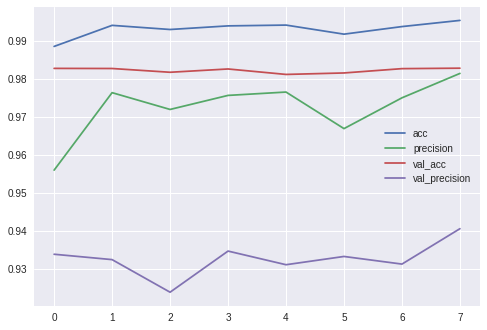

In [0]:

plt.plot(history.history["acc"], label = "acc")
plt.plot(history.history["precision"], label = "precision")

plt.plot(history.history["val_acc"], label = "val_acc")
plt.plot(history.history["val_precision"], label = "val_precision")

plt.legend()



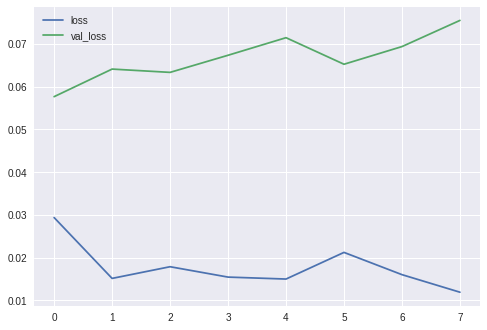

In [0]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()

In [0]:
autoencoder.save("autoencoder9.h5")

In [0]:
# tu average preciision is scikit-a
train_predikt = autoencoder.predict(vox_data[:4000])
train_predikt.shape


(4000, 20, 20, 20, 1)

In [0]:
metrics.average_precision_score(vox_data[:4000].flatten(), train_predikt.flatten())

0.9976354882889167

In [0]:
# prvih 200 epoha treniranja.. unutar iskoci iz lok optimuma
history.history.keys()

dict_keys(['loss', 'acc', 'precision'])

In [0]:
# evaluation on validation data
train_predikt_test = autoencoder.predict(vox_data_test)
train_predikt_test.shape

(4031, 20, 20, 20, 1)

In [0]:
# evaluation on validation data
metrics.average_precision_score(vox_data_test.flatten(), train_predikt_test.flatten())

0.9786774499610918

In [0]:
!kill

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


In [0]:
!kill -9 -1